In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 6
multi_gpus = None #[0, 1, 2]
b = 6
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [10]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [11]:
new_ind = np.arange(len(X_train))

In [12]:
print(len(new_ind))

697


In [13]:
train_sampler = SubsetRandomSampler(new_ind)

In [14]:
# define dataset

In [15]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [16]:
if zero_one_normalize:
    intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)

torch.Size([1, 96, 114, 96])


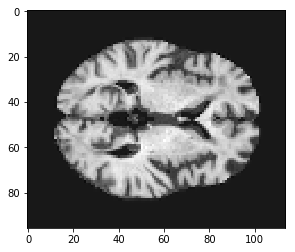

In [17]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [18]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(1134, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
            
        h = F.elu(self.pif(x))
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [19]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [20]:
print(net)

SixtyFourNet(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 3, kernel_size=(3, 3, 

In [21]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 519979


# Training

In [22]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies: {}".format(best_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [23]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [24]:
r = 0

In [25]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/experiment/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
torch.Size([1, 96, 114, 96])
117


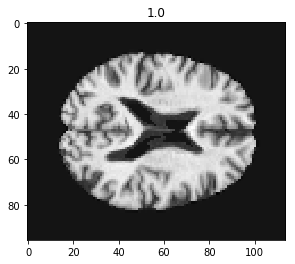

[0,    20] loss: 0.69674
[0,    40] loss: 0.69821
[0,    60] loss: 0.67865
[0,    80] loss: 0.69502
[0,   100] loss: 0.69390
Time elapsed: 0h:0m:21s
train accuracy_score: 53.95 %
train balanced_accuracy: 53.43 %
train auc_score: 53.43 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687892
[1,    20] loss: 0.69202
[1,    40] loss: 0.69510
[1,    60] loss: 0.69540
[1,    80] loss: 0.69399
[1,   100] loss: 0.69035
Time elapsed: 0h:0m:44s
train accuracy_score: 50.50 %
train balanced_accuracy: 49.69 %
train auc_score: 49.69 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694388
[2,    20] loss: 0.68791
[2,    40] loss: 0.70109
[2,    60] loss: 0.69246
[2,    80] loss: 0.69256
[2,   100] loss: 0.69039
Time elapsed: 0h:1m:7s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.55 %
train auc_score: 52.55 %
val accuracy_score: 74.00 %
val balanced_accuracy: 70.83 %
val auc_score: 70.83 %
Val lo

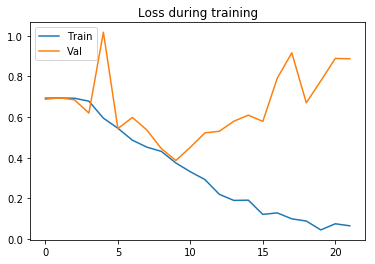

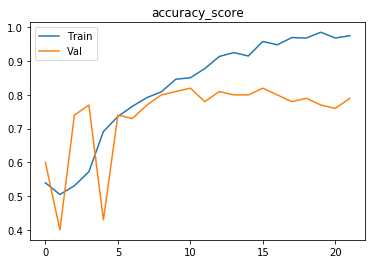

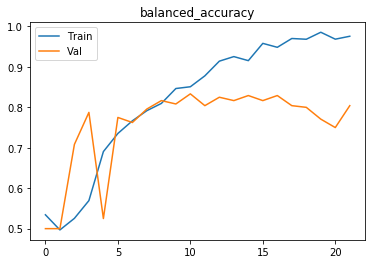

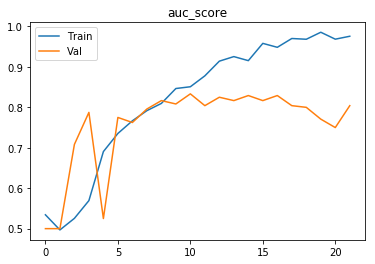

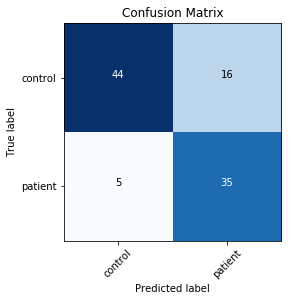

Starting trial 1
torch.Size([1, 96, 114, 96])
117


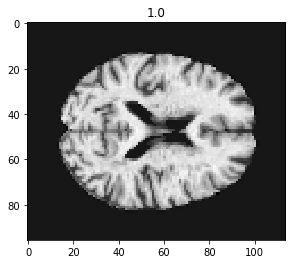

[0,    20] loss: 0.69510
[0,    40] loss: 0.69727
[0,    60] loss: 0.69554
[0,    80] loss: 0.69234
[0,   100] loss: 0.69999
Time elapsed: 0h:0m:21s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.76 %
train auc_score: 50.76 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712673
[1,    20] loss: 0.69534
[1,    40] loss: 0.69259
[1,    60] loss: 0.69494
[1,    80] loss: 0.69369
[1,   100] loss: 0.69541
Time elapsed: 0h:0m:45s
train accuracy_score: 48.78 %
train balanced_accuracy: 48.44 %
train auc_score: 48.44 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697943
[2,    20] loss: 0.69773
[2,    40] loss: 0.69256
[2,    60] loss: 0.69747
[2,    80] loss: 0.69281
[2,   100] loss: 0.68965
Time elapsed: 0h:1m:8s
train accuracy_score: 49.35 %
train balanced_accuracy: 48.72 %
train auc_score: 48.72 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

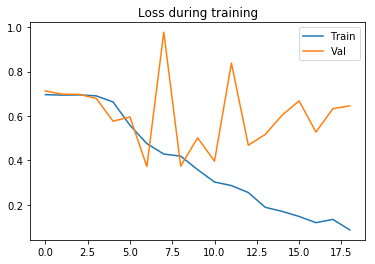

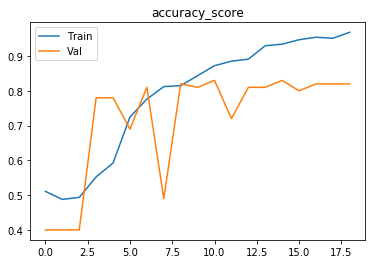

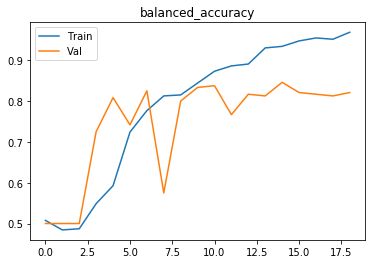

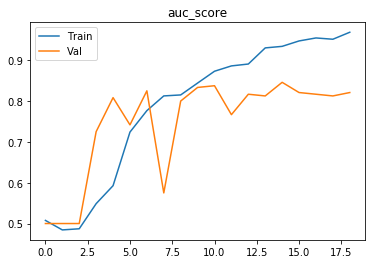

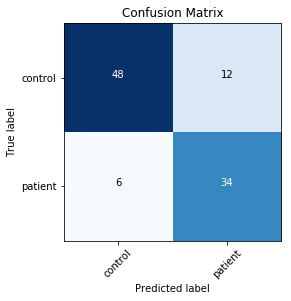

Starting trial 2
torch.Size([1, 96, 114, 96])
117


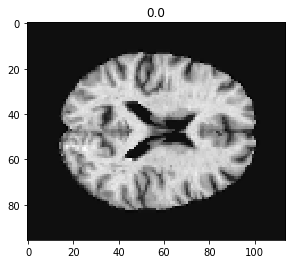

[0,    20] loss: 0.70494
[0,    40] loss: 0.69811
[0,    60] loss: 0.69416
[0,    80] loss: 0.69490
[0,   100] loss: 0.69936
Time elapsed: 0h:0m:21s
train accuracy_score: 47.63 %
train balanced_accuracy: 47.88 %
train auc_score: 47.88 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.682880
[1,    20] loss: 0.69566
[1,    40] loss: 0.69845
[1,    60] loss: 0.71250
[1,    80] loss: 0.69759
[1,   100] loss: 0.69092
Time elapsed: 0h:0m:44s
train accuracy_score: 48.35 %
train balanced_accuracy: 49.10 %
train auc_score: 49.10 %
val accuracy_score: 67.00 %
val balanced_accuracy: 59.17 %
val auc_score: 59.17 %
Val loss: 0.691079
[2,    20] loss: 0.69202
[2,    40] loss: 0.69756
[2,    60] loss: 0.69397
[2,    80] loss: 0.71388
[2,   100] loss: 0.69185
Time elapsed: 0h:1m:8s
train accuracy_score: 50.22 %
train balanced_accuracy: 50.90 %
train auc_score: 50.90 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
val auc_score: 51.25 %
Val lo

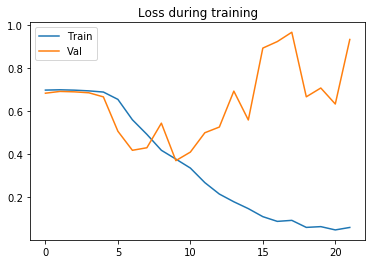

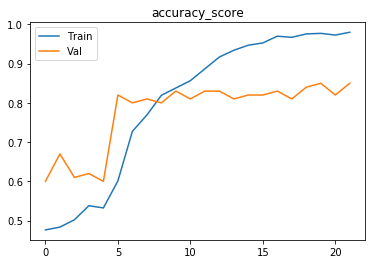

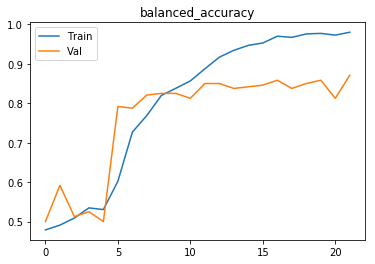

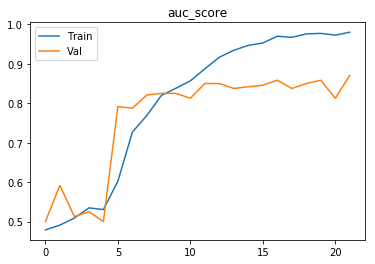

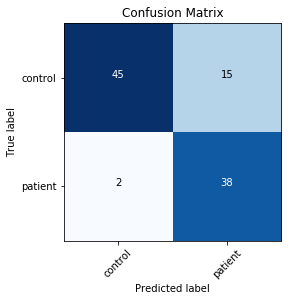

Starting trial 3
torch.Size([1, 96, 114, 96])
117


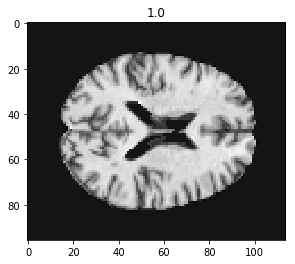

[0,    20] loss: 0.69562
[0,    40] loss: 0.69529
[0,    60] loss: 0.69927
[0,    80] loss: 0.69535
[0,   100] loss: 0.69846
Time elapsed: 0h:0m:21s
train accuracy_score: 51.36 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690686
[1,    20] loss: 0.69421
[1,    40] loss: 0.69412
[1,    60] loss: 0.69367
[1,    80] loss: 0.69136
[1,   100] loss: 0.69443
Time elapsed: 0h:0m:45s
train accuracy_score: 51.65 %
train balanced_accuracy: 51.07 %
train auc_score: 51.07 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.681696
[2,    20] loss: 0.69505
[2,    40] loss: 0.69084
[2,    60] loss: 0.69391
[2,    80] loss: 0.69147
[2,   100] loss: 0.68773
Time elapsed: 0h:1m:8s
train accuracy_score: 54.23 %
train balanced_accuracy: 54.10 %
train auc_score: 54.10 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

[24,    40] loss: 0.04294
[24,    60] loss: 0.03630
[24,    80] loss: 0.04644
[24,   100] loss: 0.01916
Time elapsed: 0h:9m:55s
train accuracy_score: 98.71 %
train balanced_accuracy: 98.71 %
train auc_score: 98.71 %
val accuracy_score: 91.00 %
val balanced_accuracy: 92.08 %
val auc_score: 92.08 %
Val loss: 0.530280
Early stopping in epoch 25
Total time elapsed: 0h:9m:57s
Writing model to disk...
Best result during training: 0.92. Saving model..
Finished fold.


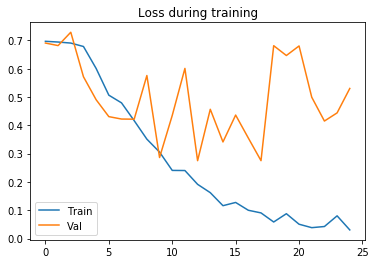

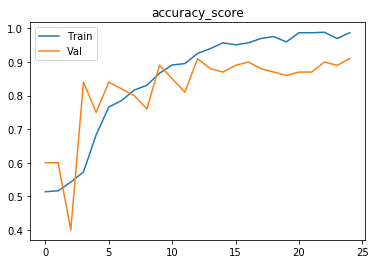

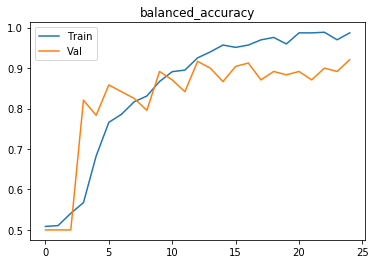

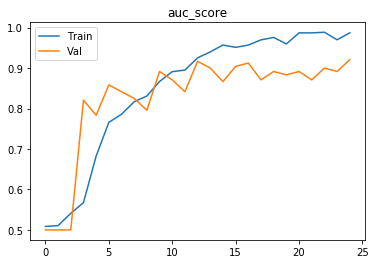

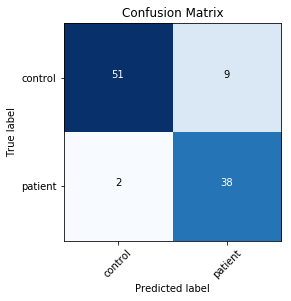

Starting trial 4
torch.Size([1, 96, 114, 96])
117


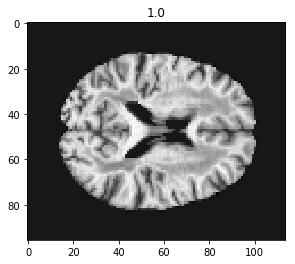

[0,    20] loss: 0.68979
[0,    40] loss: 0.70680
[0,    60] loss: 0.69410
[0,    80] loss: 0.69736
[0,   100] loss: 0.70502
Time elapsed: 0h:0m:21s
train accuracy_score: 48.35 %
train balanced_accuracy: 47.76 %
train auc_score: 47.76 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.677486
[1,    20] loss: 0.67834
[1,    40] loss: 0.72131
[1,    60] loss: 0.69693
[1,    80] loss: 0.68464
[1,   100] loss: 0.71755
Time elapsed: 0h:0m:45s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.54 %
train auc_score: 50.54 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697303
[2,    20] loss: 0.69776
[2,    40] loss: 0.68998
[2,    60] loss: 0.70716
[2,    80] loss: 0.69234
[2,   100] loss: 0.69559
Time elapsed: 0h:1m:8s
train accuracy_score: 51.51 %
train balanced_accuracy: 50.78 %
train auc_score: 50.78 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

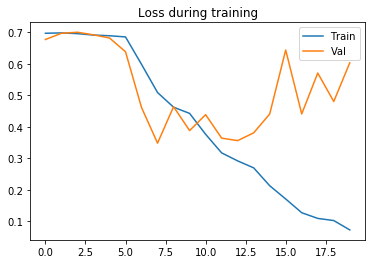

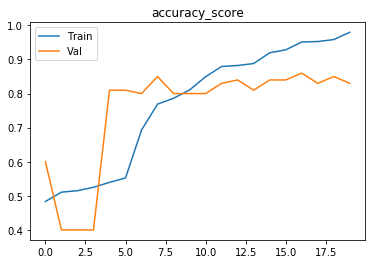

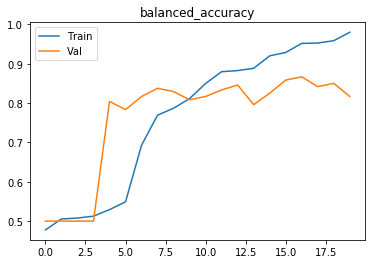

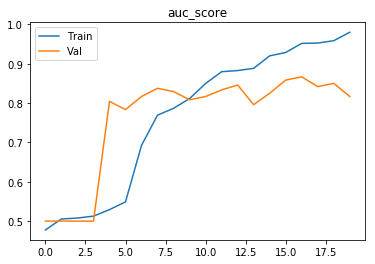

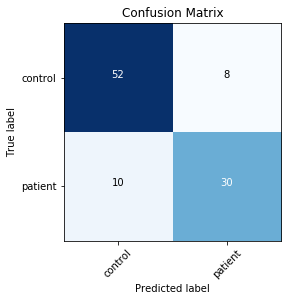

Starting trial 5
torch.Size([1, 96, 114, 96])
117


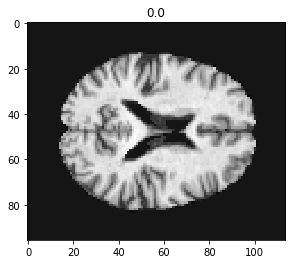

[0,    20] loss: 0.69621
[0,    40] loss: 0.69574
[0,    60] loss: 0.71145
[0,    80] loss: 0.69588
[0,   100] loss: 0.69195
Time elapsed: 0h:0m:21s
train accuracy_score: 50.50 %
train balanced_accuracy: 49.98 %
train auc_score: 49.98 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717735
[1,    20] loss: 0.69784
[1,    40] loss: 0.69335
[1,    60] loss: 0.69006
[1,    80] loss: 0.69211
[1,   100] loss: 0.70106
Time elapsed: 0h:0m:46s
train accuracy_score: 51.51 %
train balanced_accuracy: 50.55 %
train auc_score: 50.55 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.682636
[2,    20] loss: 0.68899
[2,    40] loss: 0.69806
[2,    60] loss: 0.68782
[2,    80] loss: 0.69648
[2,   100] loss: 0.69844
Time elapsed: 0h:1m:9s
train accuracy_score: 51.79 %
train balanced_accuracy: 51.30 %
train auc_score: 51.30 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
val auc_score: 51.25 %
Val lo

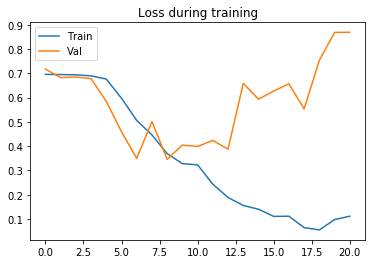

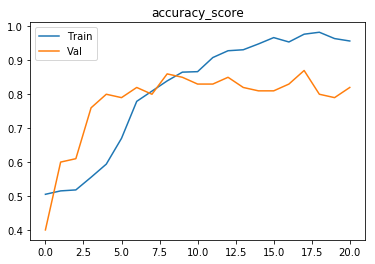

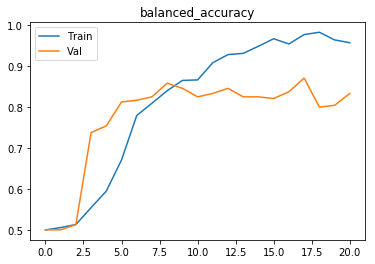

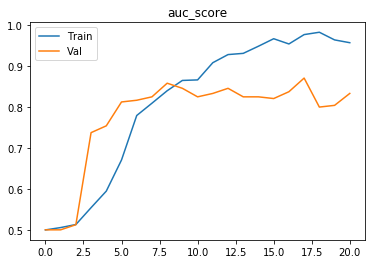

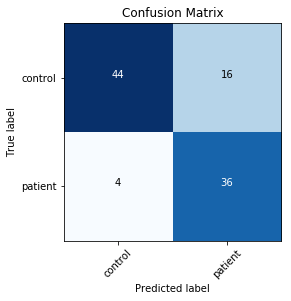

Starting trial 6
torch.Size([1, 96, 114, 96])
117


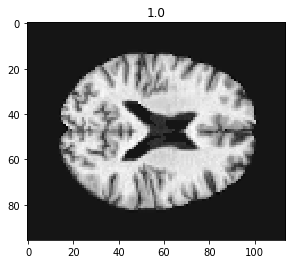

[0,    20] loss: 0.69467
[0,    40] loss: 0.69528
[0,    60] loss: 0.69492
[0,    80] loss: 0.69396
[0,   100] loss: 0.70368
Time elapsed: 0h:0m:21s
train accuracy_score: 48.78 %
train balanced_accuracy: 49.35 %
train auc_score: 49.35 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704432
[1,    20] loss: 0.69851
[1,    40] loss: 0.69658
[1,    60] loss: 0.68961
[1,    80] loss: 0.70077
[1,   100] loss: 0.69197
Time elapsed: 0h:0m:44s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.35 %
train auc_score: 50.35 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712392
[2,    20] loss: 0.69496
[2,    40] loss: 0.69345
[2,    60] loss: 0.69830
[2,    80] loss: 0.69067
[2,   100] loss: 0.69505
Time elapsed: 0h:1m:8s
train accuracy_score: 50.93 %
train balanced_accuracy: 50.51 %
train auc_score: 50.51 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

[24,    40] loss: 0.07082
[24,    60] loss: 0.04620
[24,    80] loss: 0.02379
[24,   100] loss: 0.01123
Time elapsed: 0h:9m:51s
train accuracy_score: 98.42 %
train balanced_accuracy: 98.41 %
train auc_score: 98.41 %
val accuracy_score: 88.00 %
val balanced_accuracy: 90.00 %
val auc_score: 90.00 %
Val loss: 0.701562
[25,    20] loss: 0.01223
[25,    40] loss: 0.07026
[25,    60] loss: 0.07394
[25,    80] loss: 0.07113
[25,   100] loss: 0.02102
Time elapsed: 0h:10m:15s
train accuracy_score: 97.70 %
train balanced_accuracy: 97.71 %
train auc_score: 97.71 %
val accuracy_score: 87.00 %
val balanced_accuracy: 87.92 %
val auc_score: 87.92 %
Val loss: 0.450645
Early stopping in epoch 26
Total time elapsed: 0h:10m:17s
Writing model to disk...
Best result during training: 0.90. Saving model..
Finished fold.


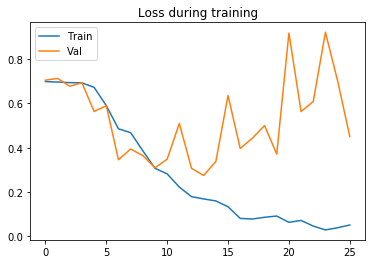

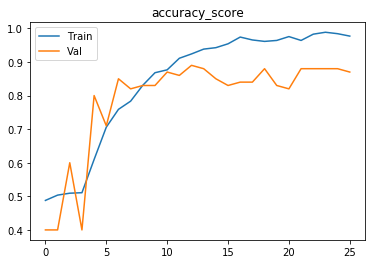

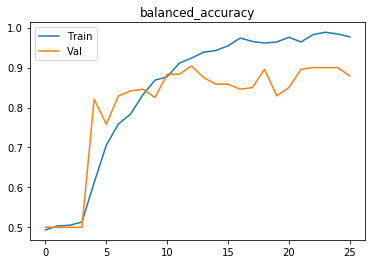

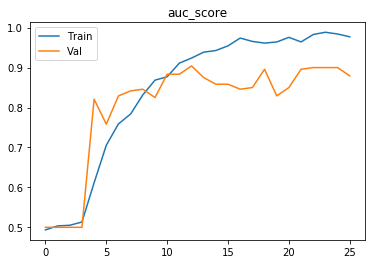

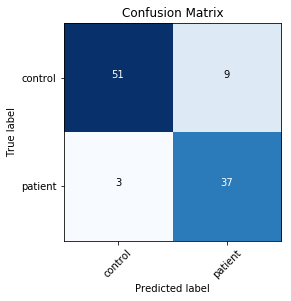

Starting trial 7
torch.Size([1, 96, 114, 96])
117


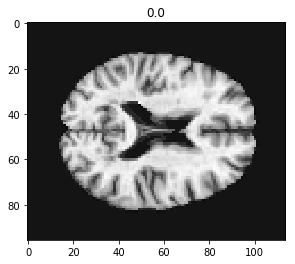

[0,    20] loss: 0.69761
[0,    40] loss: 0.71117
[0,    60] loss: 0.69567
[0,    80] loss: 0.68916
[0,   100] loss: 0.68784
Time elapsed: 0h:0m:21s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.84 %
train auc_score: 50.84 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700072
[1,    20] loss: 0.69312
[1,    40] loss: 0.69618
[1,    60] loss: 0.69226
[1,    80] loss: 0.68957
[1,   100] loss: 0.69142
Time elapsed: 0h:0m:45s
train accuracy_score: 50.22 %
train balanced_accuracy: 48.88 %
train auc_score: 48.88 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693575
[2,    20] loss: 0.68904
[2,    40] loss: 0.69529
[2,    60] loss: 0.68795
[2,    80] loss: 0.69151
[2,   100] loss: 0.69268
Time elapsed: 0h:1m:10s
train accuracy_score: 54.52 %
train balanced_accuracy: 54.19 %
train auc_score: 54.19 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val l

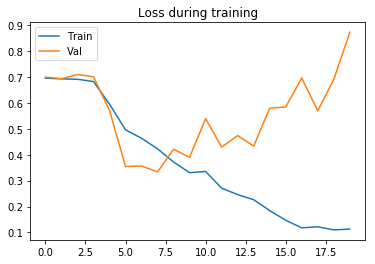

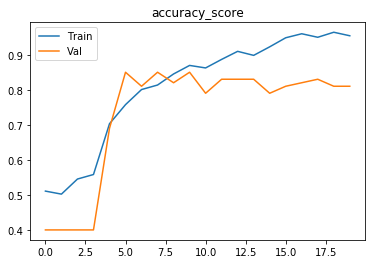

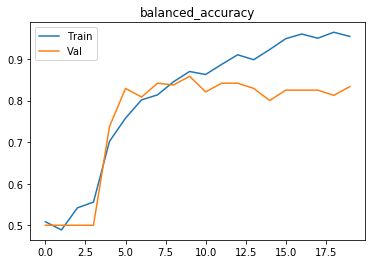

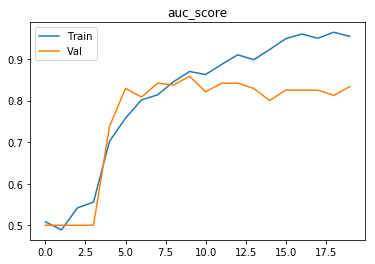

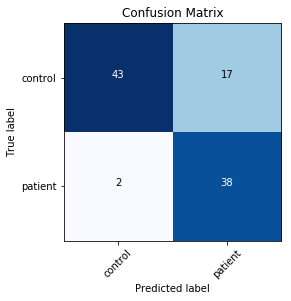

Starting trial 8
torch.Size([1, 96, 114, 96])
117


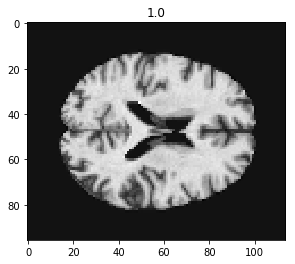

[0,    20] loss: 0.69737
[0,    40] loss: 0.69725
[0,    60] loss: 0.69426
[0,    80] loss: 0.69168
[0,   100] loss: 0.69506
Time elapsed: 0h:0m:21s
train accuracy_score: 51.22 %
train balanced_accuracy: 50.70 %
train auc_score: 50.70 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701476
[1,    20] loss: 0.69398
[1,    40] loss: 0.69934
[1,    60] loss: 0.69763
[1,    80] loss: 0.69405
[1,   100] loss: 0.68451
Time elapsed: 0h:0m:45s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.12 %
train auc_score: 50.12 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695148
[2,    20] loss: 0.69360
[2,    40] loss: 0.69423
[2,    60] loss: 0.69112
[2,    80] loss: 0.68102
[2,   100] loss: 0.69671
Time elapsed: 0h:1m:8s
train accuracy_score: 53.37 %
train balanced_accuracy: 52.86 %
train auc_score: 52.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

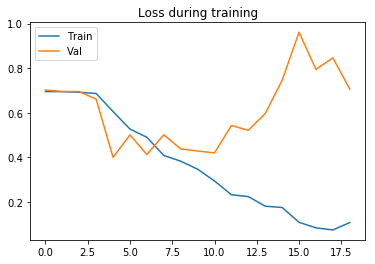

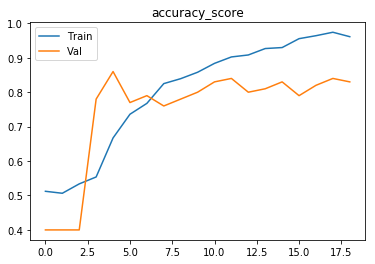

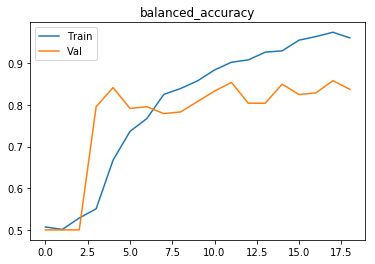

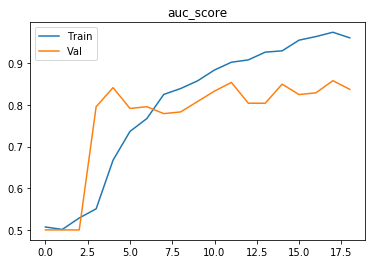

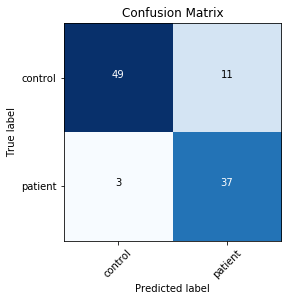

Starting trial 9
torch.Size([1, 96, 114, 96])
117


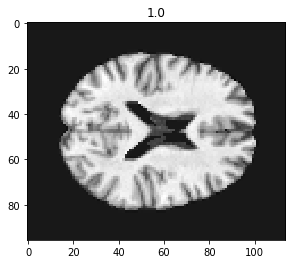

[0,    20] loss: 0.71464
[0,    40] loss: 0.69753
[0,    60] loss: 0.69413
[0,    80] loss: 0.69030
[0,   100] loss: 0.69642
Time elapsed: 0h:0m:21s
train accuracy_score: 48.35 %
train balanced_accuracy: 47.05 %
train auc_score: 47.05 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701488
[1,    20] loss: 0.68930
[1,    40] loss: 0.70166
[1,    60] loss: 0.69631
[1,    80] loss: 0.68930
[1,   100] loss: 0.69942
Time elapsed: 0h:0m:45s
train accuracy_score: 51.65 %
train balanced_accuracy: 50.40 %
train auc_score: 50.40 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696803
[2,    20] loss: 0.68973
[2,    40] loss: 0.69503
[2,    60] loss: 0.68819
[2,    80] loss: 0.68938
[2,   100] loss: 0.68844
Time elapsed: 0h:1m:8s
train accuracy_score: 53.08 %
train balanced_accuracy: 51.62 %
train auc_score: 51.62 %
val accuracy_score: 60.00 %
val balanced_accuracy: 51.67 %
val auc_score: 51.67 %
Val lo

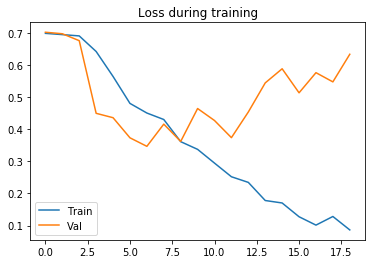

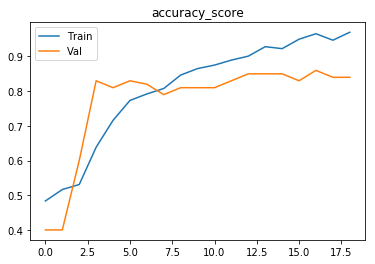

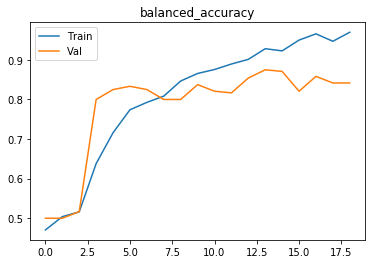

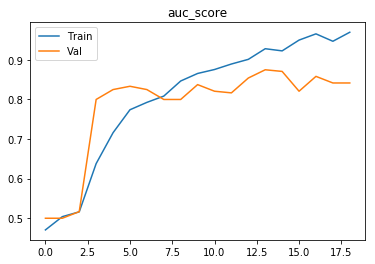

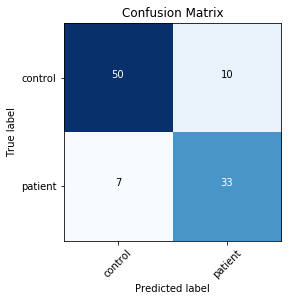

################################
################################
All accuracies: [0.8041666666666667, 0.8208333333333333, 0.8708333333333332, 0.9208333333333334, 0.8166666666666668, 0.8333333333333335, 0.8791666666666668, 0.8333333333333333, 0.8375, 0.8416666666666667]
Best accuracies: [0.8333333333333335, 0.8458333333333334, 0.8708333333333332, 0.9208333333333334, 0.8666666666666667, 0.8708333333333332, 0.9041666666666667, 0.8583333333333334, 0.8583333333333334, 0.875]
Best accuracies mean: 0.8704166666666666 All :[0.8333333333333335, 0.8458333333333334, 0.8708333333333332, 0.9208333333333334, 0.8666666666666667, 0.8708333333333332, 0.9041666666666667, 0.8583333333333334, 0.8583333333333334, 0.875]
0.8458333333333334
0.03312434485725299


In [26]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [27]:
print(np.mean(fold_metric))
print(np.std(fold_metric))

0.8458333333333334
0.03312434485725299


In [28]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [34]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=True
)

In [35]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [36]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.842680412371134
Fold 1
0.822680412371134
Fold 2
0.8729896907216494
Fold 3
0.8699656357388317
Fold 4
0.8484536082474228
Fold 5
0.8572508591065292
Fold 6
0.8387628865979382
Fold 7
0.8505841924398625
Fold 8
0.8529896907216494
Fold 9
0.8265979381443299
######## Final results ########
          0
0  0.842680
1  0.822680
2  0.872990
3  0.869966
4  0.848454
5  0.857251
6  0.838763
7  0.850584
8  0.852990
9  0.826598
Balanced accuracy mean 84.83 %
